**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import cosine_similarity

%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [2]:
# %%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes = np.max(y) + 1
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X)

    def predict(self, X):
        if self.algorithm == 'kd_tree':
            y = self.y_train[self.tree.query(X, k=self.n_neighbors,
                                             return_distance=False)]
        else:
            if self.metric == 'cosine':
                dist = cosine_similarity(X, self.X_train)
                k_val = np.argpartition(dist, -self.n_neighbors,
                                        axis=1)[:, -self.n_neighbors:]
                y = self.y_train[k_val]
            elif self.metric == 'euclidean':
                dist = pairwise_distances(X, self.X_train)
                k_val = np.argpartition(dist,
                                        self.n_neighbors)[:, :self.n_neighbors]
                y = self.y_train[k_val]
        u, indices = np.unique(y, return_inverse=True)
        u = u[np.argmax(np.apply_along_axis(np.bincount, 1,
                                            indices.reshape(y.shape),
                                            None, np.max(indices)+1), axis=1)]
        return u

    def predict_proba(self, X):
        if self.algorithm == 'kd_tree':
            y = self.y_train[self.tree.query(X, k=self.n_neighbors,
                                             return_distance=False)]
        else:
            if self.metric == 'cosine':
                dist = cosine_similarity(X, self.X_train)
                k_val = np.argpartition(dist, -self.n_neighbors,
                                        axis=1)[:, -self.n_neighbors:]
                y = self.y_train[k_val]
            elif self.metric == 'euclidean':
                dist = pairwise_distances(X, self.X_train)
                k_val = np.argpartition(dist,
                                        self.n_neighbors)[:, :self.n_neighbors]
                y = self.y_train[k_val]
        pred = np.zeros((X.shape[0], self.classes))
        for i in range(self.classes):
            pred[:, i] = (y == i).sum(axis=1) / self.n_neighbors
        return pred

    def score(self, X, y):
        pred = self.predict(X)
        return np.mean(pred == y)


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.05 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 67 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.87 ms


array([1, 2, 0, 2, 1, 0, 2, 0, 0, 1, 1, 1, 2, 0, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.83 ms


array([1, 2, 0, 2, 1, 0, 2, 0, 0, 1, 1, 1, 2, 0, 2])

In [12]:
%time clf.predict_proba(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.03 ms


array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [13]:
%time my_clf.predict_proba(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.03 ms


array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.15 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 290 µs


In [18]:
%time clf.predict(X_test)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.03 ms


array([2, 0, 0, 2, 1, 0, 1, 1, 1, 2, 1, 1, 0, 2, 0])

In [19]:
%time my_clf.predict(X_test)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.41 ms


array([2, 0, 0, 2, 1, 0, 1, 1, 1, 2, 1, 1, 0, 2, 0])

In [20]:
%time clf.predict_proba(X_test)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.98 ms


array([[0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ]])

In [21]:
%time my_clf.predict_proba(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.61 ms


array([[0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ]])

In [22]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [23]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [24]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [25]:
import re

def parse(data, target):
    pattern = r"[^a-z0-9]"
    raw = [re.sub(pattern, " ", x.lower()).split() for x in data]
    raw = np.array(raw)
    indices = [i for i, v in enumerate(raw) if v]
    data_tok = raw[indices]
    new_target = target[indices]
    return data_tok, new_target


data_tok, new_target = parse(data, target)

In [26]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [27]:
from scipy.sparse import csr_matrix

indptr = [0]
indices = []
data = []
vocabulary = {}
for d in data_tok:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))

X = csr_matrix((data, indices, indptr), dtype=int)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [28]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [29]:
from sklearn.model_selection import cross_val_score

def k_max_score(kf, X):
    x = list(range(1, 15))
    y = []
    for i in range(1, 15):
        myclf = MyKNeighborsClassifier(n_neighbors=i,
                                       algorithm='brute',
                                       metric='euclidean')
        y.append(cross_val_score(myclf, X, new_target, cv=kf.split(X)).mean())
    return np.argmax(np.array(y)) + 1, x, y

In [30]:
k, x, y = k_max_score(kf, X)

In [31]:
k

1

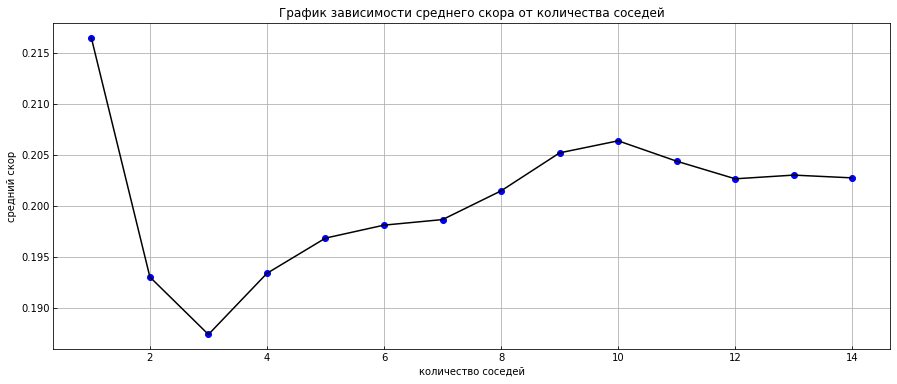

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(x, y, 'bo')
ax.plot(x, y, c='black')
ax.grid(True)
ax.set_title("График зависимости среднего скора от количества соседей")
ax.set_xlabel("количество соседей")
ax.set_ylabel("средний скор")
ax.tick_params(direction='in')

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

<br>
<br>
Используя евклидову метрику мы получим относительно большое расстояние, даже если два документа будут иметь много общих термов, но с огромной разницой в их количестве.
Косинусная метрика это же компенсирует. Поэтому будем ожидать, что скор с косинусной метрикой будет лучше.

Tf-Idf учитывает важность каждого терма.
${\displaystyle f_{t,d}\cdot \log {\frac {N}{n_{t}}}}$, где ${\displaystyle f_{t,d}}$ - частота терма в документе, N - число документов, ${n_{t}}$ - число документов с термом $t$.
То есть мы штрафуем терм, если он встречается в большинстве документов.

<center>Скоры, полученные для разных моделей для наилучшего значения $k$</center>

1. Евклидова метрика

In [33]:
myclf = MyKNeighborsClassifier(n_neighbors=1,
                               algorithm='brute',
                               metric='euclidean')
cross_val_score(myclf, X, new_target, cv=kf.split(X)).mean()

0.21646673936750271

2. Косинусная метрика

In [34]:
myclf = MyKNeighborsClassifier(n_neighbors=1,
                               algorithm='brute',
                               metric='cosine')
cross_val_score(myclf, X, new_target, cv=kf.split(X)).mean()

0.28798618684114863

3. С приминением TfIdf

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer

X_transform = TfidfTransformer().fit_transform(X)
myclf = MyKNeighborsClassifier(n_neighbors=1,
                               algorithm='brute',
                               metric='cosine')
cross_val_score(myclf, X_transform, new_target, cv=kf.split(X_transform)).mean()

0.6312250090876045

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [36]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [37]:
data_test = newsgroups['data']
target_test = newsgroups['target']

In [38]:
data_tok_test, new_test_target = parse(data_test, target_test)

In [39]:
indptr = [0]
indices = []
data = []
vocabulary = {}
for d in np.concatenate((data_tok, data_tok_test)):
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))
    
X = csr_matrix((data, indices, indptr), dtype=int)

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [40]:
X_transform = TfidfTransformer().fit_transform(X)
myclf = MyKNeighborsClassifier(n_neighbors=1,
                               algorithm='brute',
                               metric='cosine')
X_train, y_train = X_transform[:len(data_tok)], new_target
X_test, y_test = X_transform[len(data_tok):], new_test_target
myclf.fit(X_train, y_train)
myclf.score(X_test, y_test)

0.5400191544670954

Скор оказался ниже, поэтому, скорее всего мы переобучили нашу модель, в данном случае подогнали структурный параметр $k$